τ: 71.6000 s
b0: 0.0237
ω_o: 0.2793
ω_c: 0.0931
Kp: 3.9359


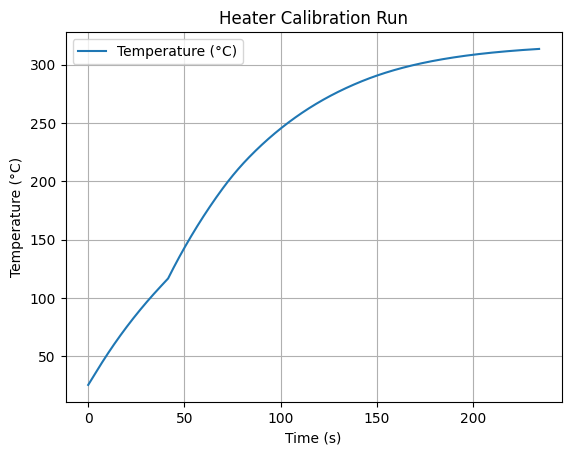

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration of the heater
from heater_configs import heaters as cfg

heater = cfg[0].clone().reset().scale_r_to(4.0).set_size(0.08, 0.07, 0.0028).label("80x70x2.8, 4R")

# Calibration run
temperature_data = []
time_data = []
power_data = []
dt = 0.1  # Time step in seconds

# Iterate until the rate of temperature increase is less than 0.1 °C/sec
heater.reset().set_power(200)
while True:
    heater.iterate(dt)

    temperature_data.append(heater.temperature)
    time_data.append(len(time_data) * dt)
    power_data.append(heater.get_power())  # Save the actual power

    # Calculate rate of temperature increase
    if len(temperature_data) > 1:
        rate_of_increase = (temperature_data[-1] - temperature_data[-2]) / dt
        if rate_of_increase < 0.1:
            break

# Estimate τ (time constant)
final_temp = temperature_data[-1]
τ_index = next(i for i, t in enumerate(temperature_data) if t >= final_temp * 0.63)

τ = time_data[τ_index]

# b0 = max derivative / power at that point
dT_dt = np.gradient(temperature_data, time_data) # the derivative of temperature with respect to time
b0 = np.max(dT_dt) / power_data[np.argmax(dT_dt)]


N = 20 # N = 3..10 how much observer speed should be faster than the system
M = 3 # M = 2..5 controller should be slower than observer

ω_o = N / τ
ω_c = ω_o / M

# Calculate beta1 / beta2
beta1 = 2 * ω_o
beta2 = ω_o ** 2

Kp = ω_c / b0

# Output the calculated coefficients
print(f"τ: {τ:.4f} s")
#print(f"T @ τ: {temperature_data[τ_index]:.2f} C")
print(f"b0: {b0:.4f}")
print(f"ω_o: {ω_o:.4f}")
print(f"ω_c: {ω_c:.4f}")
print(f"Kp: {Kp:.4f}")

# Plotting the temperature curve
plt.plot(time_data, temperature_data, label="Temperature (°C)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Heater Calibration Run")
plt.legend()
plt.grid(True)
plt.show()


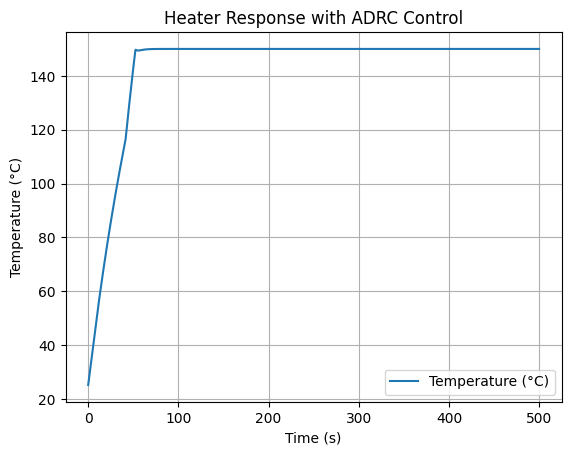

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from adrc import ADRC as ADRC

heater = cfg[0].clone().reset().scale_r_to(4).set_size(0.08, 0.07, 0.0028).label("80x70x2.8, 4R")

# Use calibrated parameters
ω_o_tuned = ω_o * 1
Kp_tuned = Kp * 1

# Create an instance of the ADRC controller with calibrated parameters
adrc = ADRC(b0, ω_o_tuned, Kp_tuned)
adrc.reset_to(heater.get_room_temp())

setpoint = 150

temperature_data = []
time_data = []
power_data = []
dt = 0.1  # Time step in seconds
time_end = 500  # Simulation period
time_data = np.arange(0, time_end, dt)

# Simulation loop
for t in time_data:
    power_output = adrc.iterate(y=heater.temperature, y_ref=setpoint, u_max=heater.get_max_power(), dt=dt)
    heater.set_power(power_output)
    heater.iterate(dt)

    # Collect data for plotting
    temperature_data.append(heater.temperature)
    power_data.append(power_output)

# Plotting the results
plt.plot(time_data, temperature_data, label="Temperature (°C)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Heater Response with ADRC Control")
plt.legend()
plt.grid(True)
plt.show()
